# Using `snorkel` on `sentiment` data

## load data

In [1]:
import pandas as pd

DATA_PATH = "yelp_labelled.txt"
data = pd.read_csv(DATA_PATH, header=None, sep="\t")
print("data shape", data.shape)
data = data.rename(columns={0: "text", 1: "label"})
data["label"] = data["label"].apply(lambda x: -1 if x == 0 else x)
data.head()

data shape (1000, 2)


,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,-1
2,Not tasty and the texture was just nasty.,-1
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### removing duplicates

`SQLLite` doesn't accept duplicate documents....

In [2]:
data[data["text"].str.contains("love this place")]

,text,label
334,I love this place.,1
814,I love this place.,1


In [3]:
data = data.drop_duplicates(subset=["text"])
data.to_csv("yelp_labelled_NO_DUPS.txt", index=False, sep="\t")
data_no_dups = pd.read_csv("yelp_labelled_NO_DUPS.txt", sep="\t")
data_no_dups[data_no_dups["text"].str.contains("love this place")]

,text,label
334,I love this place.,1


### add `spaCy` objects

In [4]:
import spacy

p = spacy.load("en_core_web_md")

In [5]:
data_no_dups["doc"] = data_no_dups["text"].apply(lambda x: p(x))
data_no_dups["tokens"] = data_no_dups["doc"].apply(lambda x: [t for t in x])

In [6]:
data_no_dups.head()

,text,label,doc,tokens
0,Wow... Loved this place.,1,"(Wow, ..., Loved, this, place, .)","[Wow, ..., Loved, this, place, .]"
1,Crust is not good.,-1,"(Crust, is, not, good, .)","[Crust, is, not, good, .]"
2,Not tasty and the texture was just nasty.,-1,"(Not, tasty, and, the, texture, was, just, nas...","[Not, tasty, and, the, texture, was, just, nas..."
3,Stopped by during the late May bank holiday of...,1,"(Stopped, by, during, the, late, May, bank, ho...","[Stopped, by, during, the, late, May, bank, ho..."
4,The selection on the menu was great and so wer...,1,"(The, selection, on, the, menu, was, great, an...","[The, selection, on, the, menu, was, great, an..."


## labeling functions

In [7]:
def get_words(tokens):
    return set([t.lemma_ for t in tokens])

pos_words = set([
    "good",
#     "awesome",
#     "great",
#     "delicious",
#     "wonderful",
#     "fast"
])

pos_tokens = [t for t in p(" ".join(pos_words))]

neg_words = set([
    "bad",
#     "terrible",
#     "horrible",
#     "unplesant",
#     "suck",
#     "slow"
])

neg_tokens = [t for t in p(" ".join(neg_words))]

strict_thresh = 0.8
low_thresh = 0.6
word_thresh = 6

In [8]:
def LF_positive_word(tokens):
    words_in_doc = get_words(tokens)
    for w in words_in_doc:
        if w in pos_words:
            return 1
    return 0
    
def LF_negative_word(tokens):
    words_in_doc = get_words(tokens)
    for w in words_in_doc:
        if w in neg_words:
            return -1
    return 0

def LF_positive_word_sim_strict(tokens):
    for w in tokens:
        for ww in pos_tokens:
            if w.similarity(ww) >= strict_thresh:
                return 1
    return 0

def LF_negative_word_sim_strict(tokens):
    for w in tokens:
        for ww in neg_tokens:
            if w.similarity(ww) >= strict_thresh:
                return 1
    return 0

def LF_positive_word_sim_loose(tokens):
    for w in tokens:
        for ww in pos_tokens:
            if w.similarity(ww) >= low_thresh:
                return 1
    return 0

def LF_negative_word_sim_loose(tokens):
    for w in tokens:
        for ww in neg_tokens:
            if w.similarity(ww) >= low_thresh:
                return 1
    return 0

def LF_not(tokens):
    if "not" in get_words(tokens):
        return 1
    return 0

def LF_exclamation(tokens):
    if "!" in get_words(tokens):
        return 1
    return 0

def LF_review_length(tokens):
    if len(tokens) <= word_thresh:
        return -1
    return 0

In [9]:
L_fns = [
    LF_positive_word, 
    LF_negative_word, 
    LF_positive_word_sim_strict, 
    LF_negative_word_sim_strict, 
    LF_positive_word_sim_loose, 
    LF_negative_word_sim_loose, 
    LF_not,
    LF_exclamation,
    LF_review_length
]

## apply labeling functions

In [10]:
import numpy as np

L = np.zeros(
    (len(L_fns), data_no_dups.shape[0])
    ).astype(int)

In [11]:
for i, lf in enumerate(L_fns):
    for j, row in data_no_dups.iterrows():
        L[i, j] = lf(row["tokens"])
L

array([[ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  1,  1, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [-1, -1,  0, ...,  0,  0,  0]])

## evaluate labeling functions

In [12]:
stats_table = np.zeros((len(L), 2))
for i in range(len(L)):
    # coverage
    stats_table[i,0] = np.sum(L[i,:] != 0)/data_no_dups.shape[0]
    # accuracy
    stats_table[i,1] = np.sum(L[i,:] == data_no_dups["label"].values)/float(np.sum(L[i,:] != 0))

In [13]:
stats_table = pd.DataFrame(stats_table, index = [lf.__name__ for lf in L_fns], columns = ["Coverage", "Accuracy"])
stats_table

,Coverage,Accuracy
LF_positive_word,0.120482,0.716667
LF_negative_word,0.032129,0.968750
LF_positive_word_sim_strict,0.166667,0.801205
LF_negative_word_sim_strict,0.017068,0.000000
LF_positive_word_sim_loose,0.803213,0.505000
LF_negative_word_sim_loose,0.706827,0.434659
LF_not,0.203815,0.187192
LF_exclamation,0.165663,0.672727
LF_review_length,0.205823,0.463415


## Look at unlabeled examples

In [14]:
for i in range(L.shape[1]):
    if not 1 in L[:,i] and not -1 in L[:,i]:
        print(data_no_dups.loc[i, "text"])

The cocktails are all handmade and delicious.
The turkey and roast beef were bland.
In summary, this was a largely disappointing dining experience.
I LOVED their mussels cooked in this wine reduction, the duck was tender, and their potato dishes were delicious.
Will go back next trip out.
Phenomenal food, service and ambiance.
We waited for forty five minutes in vain.
Their menu is diverse, and reasonably priced.
The atmosphere is modern and hip, while maintaining a touch of coziness.
I ordered the Lemon raspberry ice cocktail which was also incredible.
The live music on Fridays totally blows.
I've lived here since 1979 and this was the first (and last) time I've stepped foot into this place.
Must have been an off night at this place.
The sides are delish - mixed mushrooms, yukon gold puree, white corn - beateous.
My friend loved the salmon tartar.
The service was a bit lacking.
I loved the bacon wrapped dates.
As for the "mains," also uninspired.
The seafood was fresh and generous in 

## Look at majority vote

In [15]:
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt

L_train = sparse.csr_matrix(L.T)

In [16]:
mv_labels = np.sign(np.sum(L.T,1))
print ('Coverage of Majority Vote on Train Set: ', np.sum(np.sign(np.sum(np.abs(L.T),1)) != 0)/float(data_no_dups.shape[0]))
print ('Accuracy of Majority Vote on Train Set: ', np.mean(mv_labels == data_no_dups["label"].values))

Coverage of Majority Vote on Train Set:  0.9206827309236948
Accuracy of Majority Vote on Train Set:  0.4397590361445783


## `snorkel` Generative model

In [17]:
gen_model = GenerativeModel()

gen_model.train(L.T, epochs=100, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


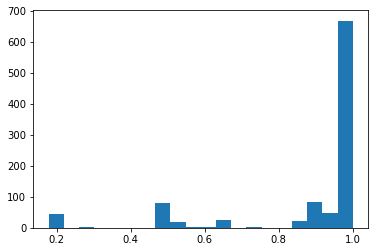

In [18]:
plt.hist(train_marginals, bins=20)
plt.show()

In [19]:
learned_table = gen_model.learned_lf_stats()
empirical_acc = stats_table.values[:,1]
learned_acc = learned_table.values[:,0]
compared_stats = pd.DataFrame(np.stack((empirical_acc, learned_acc)).T,
                             index = [lf.__name__ for lf in L_fns],
                             columns=['Empirical Acc.', 'Learned Acc.'])

compared_stats

,Empirical Acc.,Learned Acc.
LF_positive_word,0.716667,0.843874
LF_negative_word,0.968750,0.829018
LF_positive_word_sim_strict,0.801205,0.835431
LF_negative_word_sim_strict,0.000000,0.829664
LF_positive_word_sim_loose,0.505000,0.898254
LF_negative_word_sim_loose,0.434659,0.887147
LF_not,0.187192,0.849095
LF_exclamation,0.672727,0.847506
LF_review_length,0.463415,0.817487


In [21]:
labels = 2 * (train_marginals >= 0.8) - 1
print ('Coverage of Generative Model on Train Set:', np.sum(train_marginals != 0.5)/float(len(train_marginals)))
print ('Accuracy of Generative Model on Train Set:', np.mean(labels == data_no_dups["label"].values))

Coverage of Generative Model on Train Set: 0.9206827309236948
Accuracy of Generative Model on Train Set: 0.5020080321285141
